In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

mi.set_variant('cuda_ad_rgb')

from mitsuba import ScalarTransform4f as T

In [2]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'sdf_integrator',
    },
    'sensor': {
        'type': 'perspective',
        'fov': 39.3077,
        'to_world': T.look_at(
            origin=[0, 0, 5],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        'sampler': {
            'type': 'independent',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 512,
            'height': 512,
            'rfilter': {
                'type': 'gaussian',
            },
            'pixel_format': 'rgb',
            'sample_border': True,
        },
    },
    'sphere': {
        'type': 'sphere',
        'to_world': T.translate([0, 0, 0]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {'type': 'rgb', 'value': [0, 1, 0]},
        },
    },
})


def relse(a, b):
    return dr.sqr(a - b) / (dr.sqr(b) + 1e-2)

def relmse(a, b):
    return dr.mean(relse(a, b))

params = mi.traverse(scene)
print(params)

# key = 'sphere.bsdf.reflectance.value'
key = 'sphere.to_world'

SceneParameters[
  ------------------------------------------------------------------------------------
  Name                             Flags    Type  Parent
  ------------------------------------------------------------------------------------
  sensor.near_clip                          float PerspectiveCamera
  sensor.far_clip                           float PerspectiveCamera
  sensor.shutter_open                       float PerspectiveCamera
  sensor.shutter_open_time                  float PerspectiveCamera
  sensor.film.size                          ScalarVector2u HDRFilm
  sensor.film.crop_size                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                   ScalarPoint2u HDRFilm
  sensor.x_fov                     ∂, D     Float PerspectiveCamera
  sensor.to_world                  ∂, D     Transform4f PerspectiveCamera
  sphere.bsdf.reflectance.value    ∂        Color3f SRGBReflectanceSpectrum
  sphere.to_world                  ∂, D     Transform4f Sphere

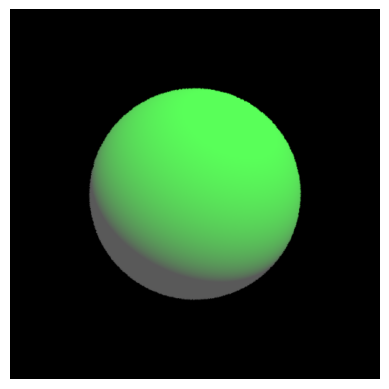

In [3]:
image_ref = mi.render(scene, params, seed=0, spp=1)
plt.axis('off')
plt.imshow(mi.util.convert_to_bitmap(image_ref));

In [4]:
# opt = mi.ad.Adam(lr=0.1)
# params[key] = mi.Color3f(1, 1, 0)

# opt[key] = params[key]
# params.update(opt);

# for i in range(25):
#     image = mi.render(scene, params, seed=0, spp=1)

#     loss = relmse(image, image_ref)
#     dr.backward(loss)

#     opt.step()

#     opt[key] = dr.clamp(opt[key], 0.0, 1.0)

#     params.update(opt)

#     print(f'Iteration {i} -- loss {loss[0]:.3e} --', end='\r')
# print()

# image = mi.render(scene, params, seed=0)

# plt.axis('off')
# plt.imshow(mi.util.convert_to_bitmap(image));

# print(params[key])

Remapping colors within range: [-1.21, 1.21]


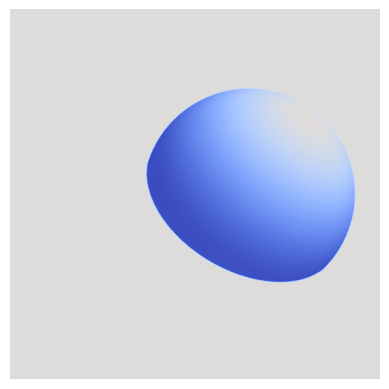

In [5]:
def apply_transformation(params, trans):
    params[key] = mi.Transform4f.translate([trans.x, trans.y, trans.z])
    params.update()

def convert_to_lum(grad_tensor):
    grad_color = dr.unravel(mi.Color3f, dr.ravel(grad_tensor[...,:3]))
    grad_lum = mi.luminance(grad_color)
    return mi.TensorXf(grad_lum, shape=(grad_tensor.shape[0], grad_tensor.shape[1]))

trans = mi.Vector3f(0.5, 0, 0)
dr.enable_grad(trans)
apply_transformation(params, trans)

image = mi.render(scene, params, seed=0, spp=16)

dr.forward(trans)

# Fetch the image gradient values
grad_image = dr.grad(image)
grad_image = convert_to_lum(grad_image)

cmap = cm.coolwarm
vlim = dr.max(dr.abs(grad_image))[0]
print(f'Remapping colors within range: [{-vlim:.2f}, {vlim:.2f}]')

plt.axis('off')
plt.imshow(grad_image, cmap=cm.coolwarm, vmin=-vlim, vmax=vlim);

Iteration 14 -- loss 2.740e-01 --
[[[1, 0, 0, 1.45274],
  [0, 1, 0, 1.29908],
  [0, 0, 1, 1.32145],
  [0, 0, 0, 1]]]


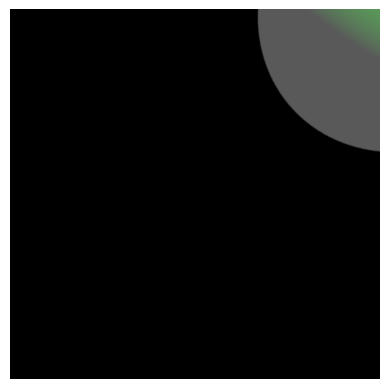

In [6]:
opt = mi.ad.Adam(lr=0.1)
opt['trans'] = mi.Vector3f(0.5, 0, 0)

def apply_transformation(params, opt):
    params[key] = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, opt['trans'].z])
    params.update()

for i in range(15):
    apply_transformation(params, opt)

    image = mi.render(scene, params, seed=0, spp=1)

    loss = relmse(image, image_ref)
    
    trans_grad = mi.Vector3f(0)
    
    for c in range(3):
        grad_in = mi.Vector3f(0, 0, 0)
        grad_in[c] = 1
        dr.set_grad(opt['trans'], grad_in)
        dr.enqueue(dr.ADMode.Forward, opt['trans'])
        dr.traverse(type(opt['trans']), dr.ADMode.Forward, flags=dr.ADFlag.ClearInput)
        trans_grad[c] = dr.grad(loss)

    dr.set_grad(opt['trans'], trans_grad)

    opt.step()

    print(f'Iteration {i} -- loss {loss[0]:.3e} --', end='\r')
print()

image = mi.render(scene, params, seed=0)

plt.axis('off')
plt.imshow(mi.util.convert_to_bitmap(image));

print(params[key])

In [7]:
# opt = mi.ad.Adam(lr=0.1)
# opt['trans'] = mi.Vector3f(0.5, 0, 0)

# def apply_transformation(params, opt):
#     params[key] = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, opt['trans'].z])
#     params.update()

# for i in range(15):
#     apply_transformation(params, opt)

#     image = mi.render(scene, params, seed=0, spp=1)

#     loss = relmse(image, image_ref)
#     dr.backward(loss)

#     opt.step()

#     print(f'Iteration {i} -- loss {loss[0]:.3e} --', end='\r')
# print()

# image = mi.render(scene, params, seed=0)

# plt.axis('off')
# plt.imshow(mi.util.convert_to_bitmap(image));

# print(params[key])

In [62]:
from mitsuba import Transform4f as T4f

def eval(position):
    A = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)
    scale = 2

    A_inv = A.inverse()
    transformed_p = A_inv.transform_affine(position)
    p = transformed_p / scale
    norm_p = dr.norm(p)

    f = scale * (norm_p - 1.0)
    p_norm = p / norm_p
    dfdx = dr.transpose(mi.Matrix3f(A_inv.matrix))@p_norm

    return f, dfdx

p = mi.Point3f(1, 2, 3)
dr.enable_grad(p)

f, n = eval(p)
dr.backward(f)
dfdx = dr.grad(p)

print(f, n)
print(dfdx)
print(n)

[-1.999999761581421] [[-0.07708980143070221, -0.8744156956672668, -0.4790138304233551]]
[[-0.07708980143070221, -0.8744156956672668, -0.4790138304233551]]
[[-0.07708980143070221, -0.8744156956672668, -0.4790138304233551]]
